# Denoising

> Tutorial denoising


In [ ]:
#| default_exp tutorial_denoising

In [ ]:
from bioMONAI.data import *
from bioMONAI.transforms import *
from bioMONAI.core import *
from bioMONAI.core import Path
from bioMONAI.data import get_image_files, get_target, RandomSplitter
from bioMONAI.losses import *
from bioMONAI.losses import SSIMLoss
from bioMONAI.metrics import *
from bioMONAI.datasets import download_file


In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
device = get_device()
print(device)

cuda


### Download Data

In the next cell, we will download the dataset required for this tutorial. The dataset is hosted online, and we will use the `download_file` function from the `bioMONAI` library to download and extract the files. 

>- You can change the `output_directory` variable to specify a different directory where you want to save the downloaded files.
>- The `url` variable contains the link to the dataset. If you have a different dataset, you can replace this URL with the link to your dataset.
>- By default, we are downloading only the first two images. You can modify the code to download more images if needed.

Make sure you have enough storage space in the specified directory before downloading the dataset.

In [ ]:
# Specify the directory where you want to save the downloaded files
output_directory = "../_data/U2OS"
# Define the base URL for the dataset
url = 'http://csbdeep.bioimagecomputing.com/example_data/snr_7_binning_2.zip'

# Download only the first two images
download_file(url, output_directory, extract=True)

The file has been downloaded and saved to: ../_data/U2OS
Decompression (if needed) has been handled automatically.


### Prepare Data for Training

In the next cell, we will prepare the data for training. We will specify the path to the training images and define the batch size and patch size. Additionally, we will apply several transformations to the images to augment the dataset and improve the model's robustness.

- `X_path`: The path to the directory containing the low-resolution training images.
- `bs`: The batch size, which determines the number of images processed together in one iteration.
- `patch_size`: The size of the patches to be extracted from the images.
- `itemTfms`: A list of item-level transformations applied to each image, including random cropping, rotation, and flipping.
- `batchTfms`: A list of batch-level transformations applied to each batch of images, including intensity scaling.
- `get_target_fn`: A function to get the corresponding ground truth images for the low-resolution images.

>You can customize the following parameters to suit your needs:
>- Change the `X_path` variable to point to a different dataset.
>- Adjust the `bs` and `patch_size` variables to match your hardware capabilities and model requirements.
>- Modify the transformations in `itemTfms` and `batchTfms` to include other augmentations or preprocessing steps.

After defining these parameters and transformations, we will create a `BioDataLoaders` object to load the training and validation datasets.

In [ ]:
X_path = '../_data/U2OS/128a57f165e1044e34d9a6ef46e66b3c-snr_7_binning_2.zip.unzip/train/low/'

bs = 32
patch_size = 96

itemTfms = [RandCropND(patch_size), RandRot90(prob=.75), RandFlip(prob=0.75)]
batchTfms = [ScaleIntensityPercentiles()]

get_target_fn = get_target('GT', same_filename=True, relative_path=True)

data = BioDataLoaders.from_folder(
    X_path,                 # input images
    get_target_fn,          # target images
    valid_pct=0.05,         # percentage of data for the validation set
    seed=42,                # seed for random number generator  
    item_tfms=itemTfms,     # item transformations
    batch_tfms=batchTfms,   # batch transformations
    show_summary=False,     # print summary of the dataset
    bs = bs,                # batch size
    )

# print length of training and validation datasets
print('train images:', len(data.train_ds.items), '\nvalidation images:', len(data.valid_ds.items))

train images: 2335 
validation images: 122


### Visualize a Batch of Training Data

In the next cell, we will visualize a batch of training data to get an idea of what the images look like after applying the transformations. This step is crucial to ensure that the data augmentation and preprocessing steps are working as expected.

- `data.show_batch(cmap='magma')`: This function will display a batch of images from the training dataset using the 'magma' colormap.

> Change the `cmap` parameter to use a different colormap (e.g., 'gray', 'viridis', 'plasma') based on your preference.

Visualizing the data helps in understanding the dataset better and ensures that the transformations are applied correctly.

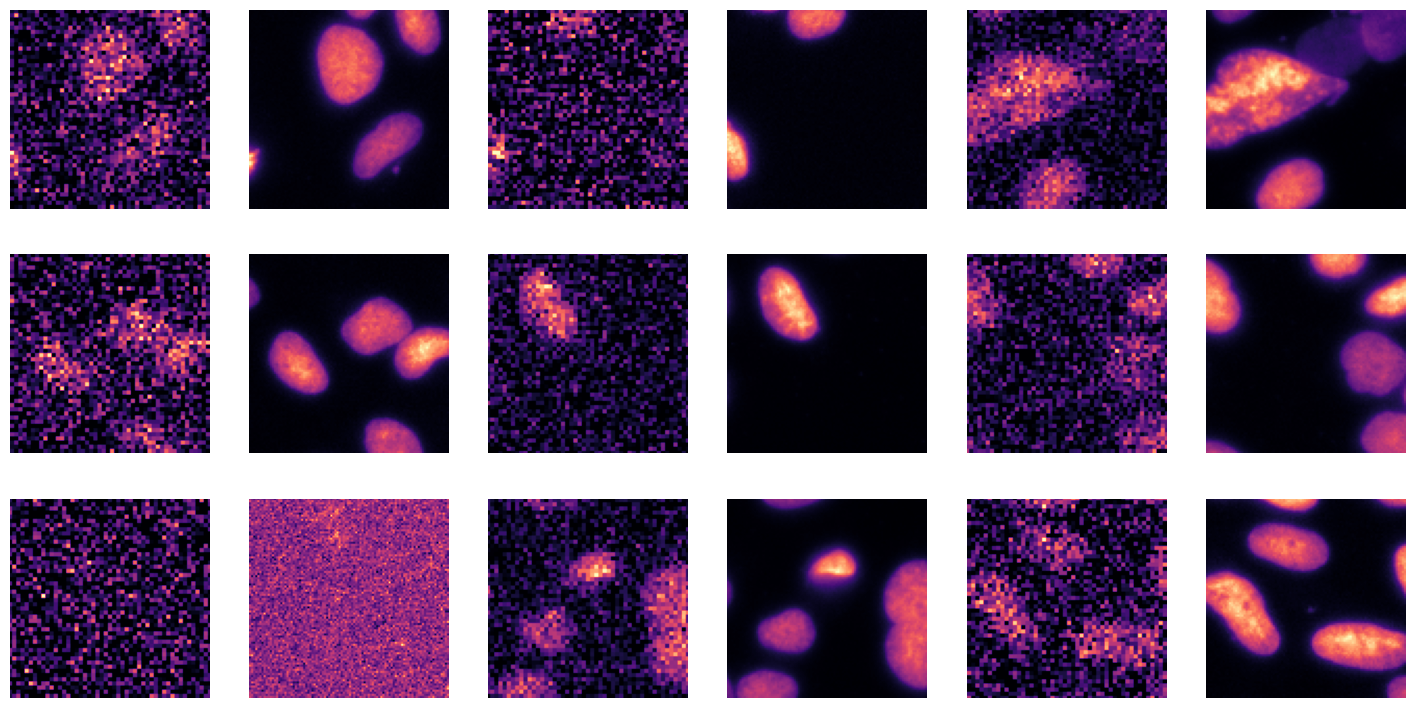

In [ ]:
data.show_batch(cmap='magma')

### Define and Train the Model

In the next cell, we will define a 2D U-Net model using the `create_unet_model` function from the `bioMONAI` library. The U-Net model is a popular architecture for image segmentation tasks, and it can be customized to suit various applications.

- `resnet34`: The backbone of the U-Net model. You can replace this with other backbones like `resnet18`, `resnet50`, etc., depending on your requirements.
- `1`: The number of output channels. For grayscale images, this should be set to 1. For RGB images, set it to 3.
- `(128,128)`: The input size of the images. Adjust this based on the size of your input images.
- `True`: Whether to use pre-trained weights for the backbone. Set this to `False` if you want to train the model from scratch.
- `n_in=1`: The number of input channels. For grayscale images, this should be set to 1. For RGB images, set it to 3.
- `cut=7`: The layer at which to cut the backbone. Adjust this based on the architecture of the backbone.

>You can customize the following parameters to suit your needs:
>- Change the backbone to a different architecture.
>- Adjust the input and output channels based on your dataset.
>- Modify the input size to match the dimensions of your images.
>- Set `pretrained` to `False` if you want to train the model from scratch.

After defining the model, we will proceed to train it using the `fastTrainer` class. The training process involves fine-tuning the model for a specified number of epochs and evaluating its performance on the validation dataset.

In [ ]:
from bioMONAI.nets import create_unet_model, resnet34

model = create_unet_model(resnet34, 1, (128,128), True, n_in=1, cut=7)

In [ ]:
loss = CombinedLoss(mse_weight=0.8, mae_weight=0.1)

metrics = [MSEMetric(), MAEMetric(), SSIMMetric(2)]

trainer = fastTrainer(data, model, loss_fn=loss, metrics=metrics, show_summary=False)


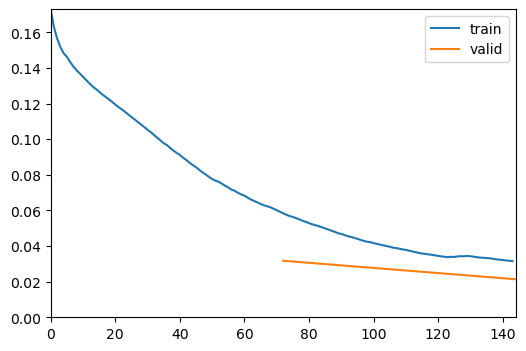

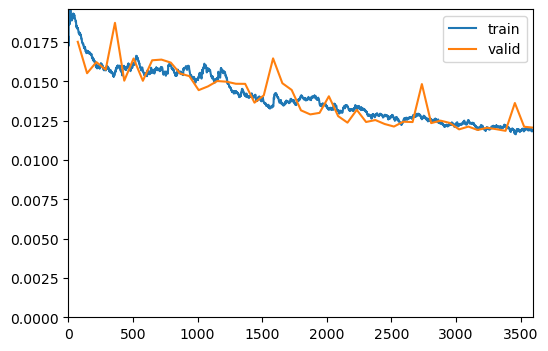

In [ ]:
trainer.fine_tune(50, freeze_epochs=2)

### Show Results

In the next cell, we will visualize the results of the trained model on a batch of validation data. This step helps in understanding how well the model has learned to denoise the images.

- `trainer.show_results(cmap='magma')`: This function will display a batch of images from the validation dataset along with their corresponding denoised outputs using the 'magma' colormap.

Visualizing the results helps in assessing the performance of the model and identifying any areas that may need further improvement.m

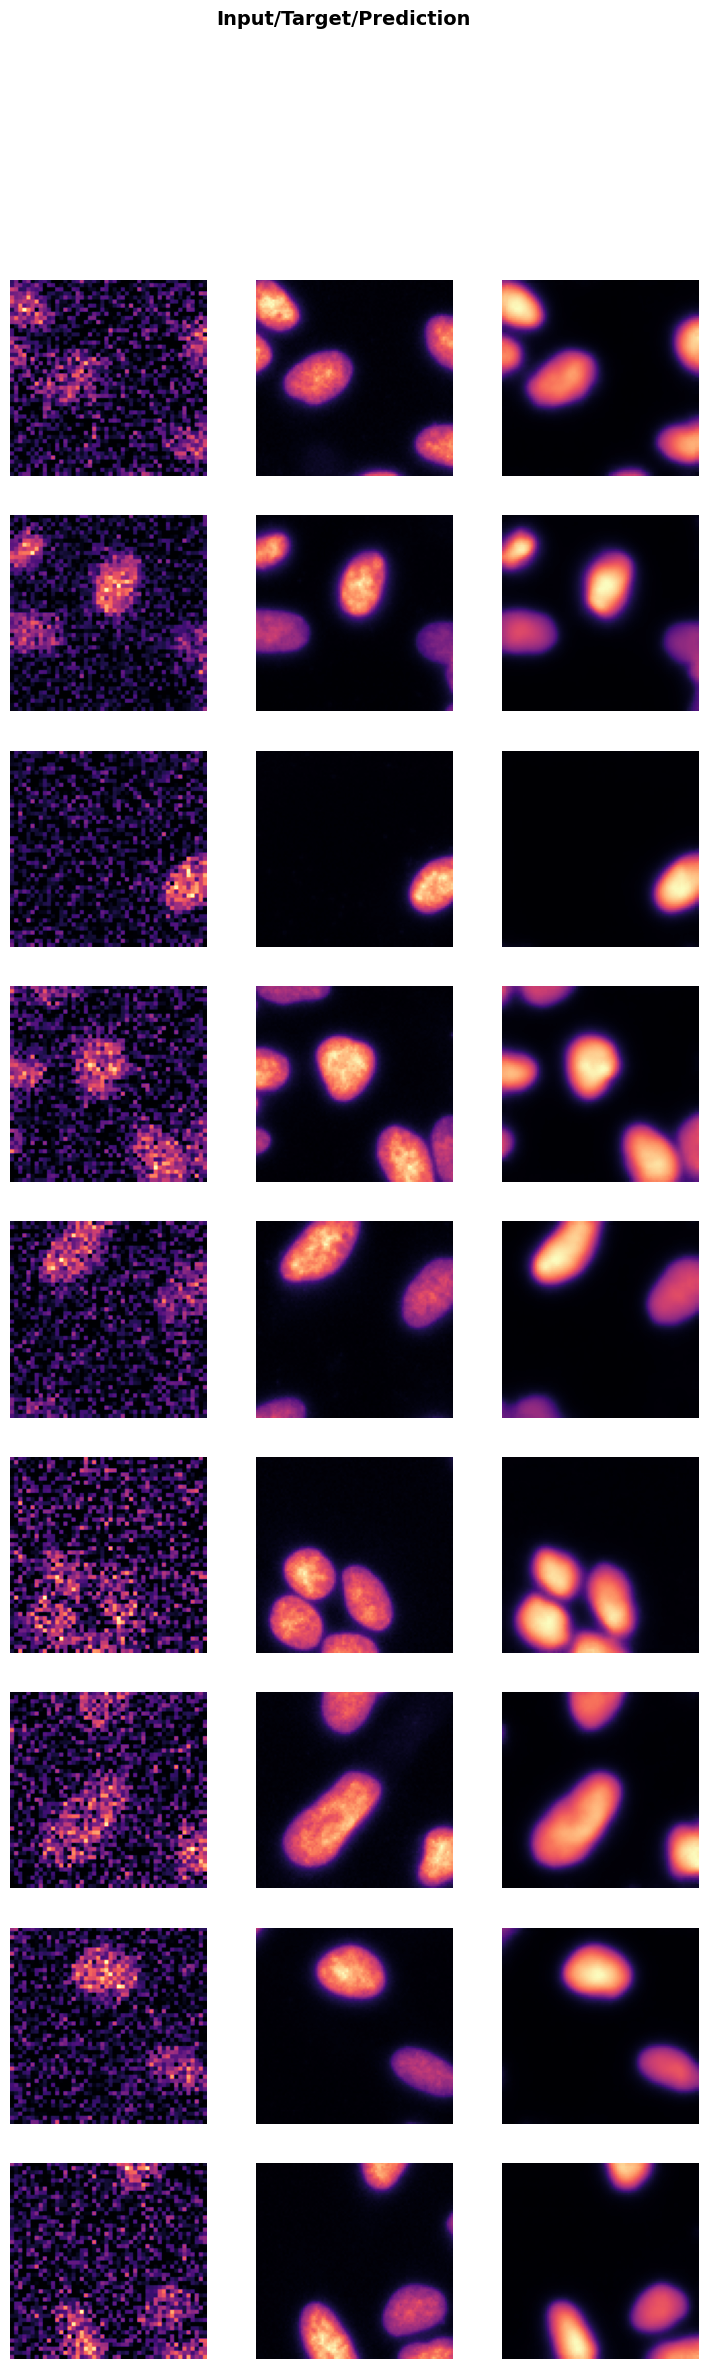

In [ ]:
trainer.show_results(cmap='magma')

### Save the Trained Model

In the next cell, we will save the trained model to a file. This step is crucial to preserve the model's weights and architecture, allowing you to load and use the model later without retraining it.

- `trainer.save('tmp-model')`: This function saves the model to a file named 'tmp-model'. You can change the filename to something more descriptive based on your project.

> Suggestions for customization:
>- Change the filename to include details like the model architecture, dataset, or date (e.g., 'unet_resnet34_U2OS_2023').
>- Save the model in a specific directory by providing the full path (e.g., 'models/unet_resnet34_U2OS_2023').
>- Save additional information like training history, metrics, or configuration settings in a separate file for better reproducibility.

Saving the model ensures that you can easily share it with others or deploy it in a production environment without needing to retrain it.

In [ ]:
# trainer.save('tmp-model')

### Evaluate the Model on Test Data

In the next cell, we will evaluate the performance of the trained model on unseen test data. This step is crucial to get an unbiased evaluation of the model's performance and understand how well it generalizes to new data.

- `test_X_path`: The path to the directory containing the low-resolution test images.
- `test_data`: A `DataLoader` object created from the test images.
- `evaluate_model(trainer, test_data, metrics=SSIMMetric(2))`: This function evaluates the model on the test dataset using the specified metrics (in this case, SSIM).

> Suggestions for customization:
>- Change the `test_X_path` variable to point to a different test dataset.
>- Add more metrics to the `metrics` parameter to get a comprehensive evaluation (e.g., `MSEMetric()`, `MAEMetric()`).
>- Save the evaluation results to a file for further analysis or reporting.

Evaluating the model on test data helps in understanding its performance in real-world scenarios and identifying any areas that may need further improvement.

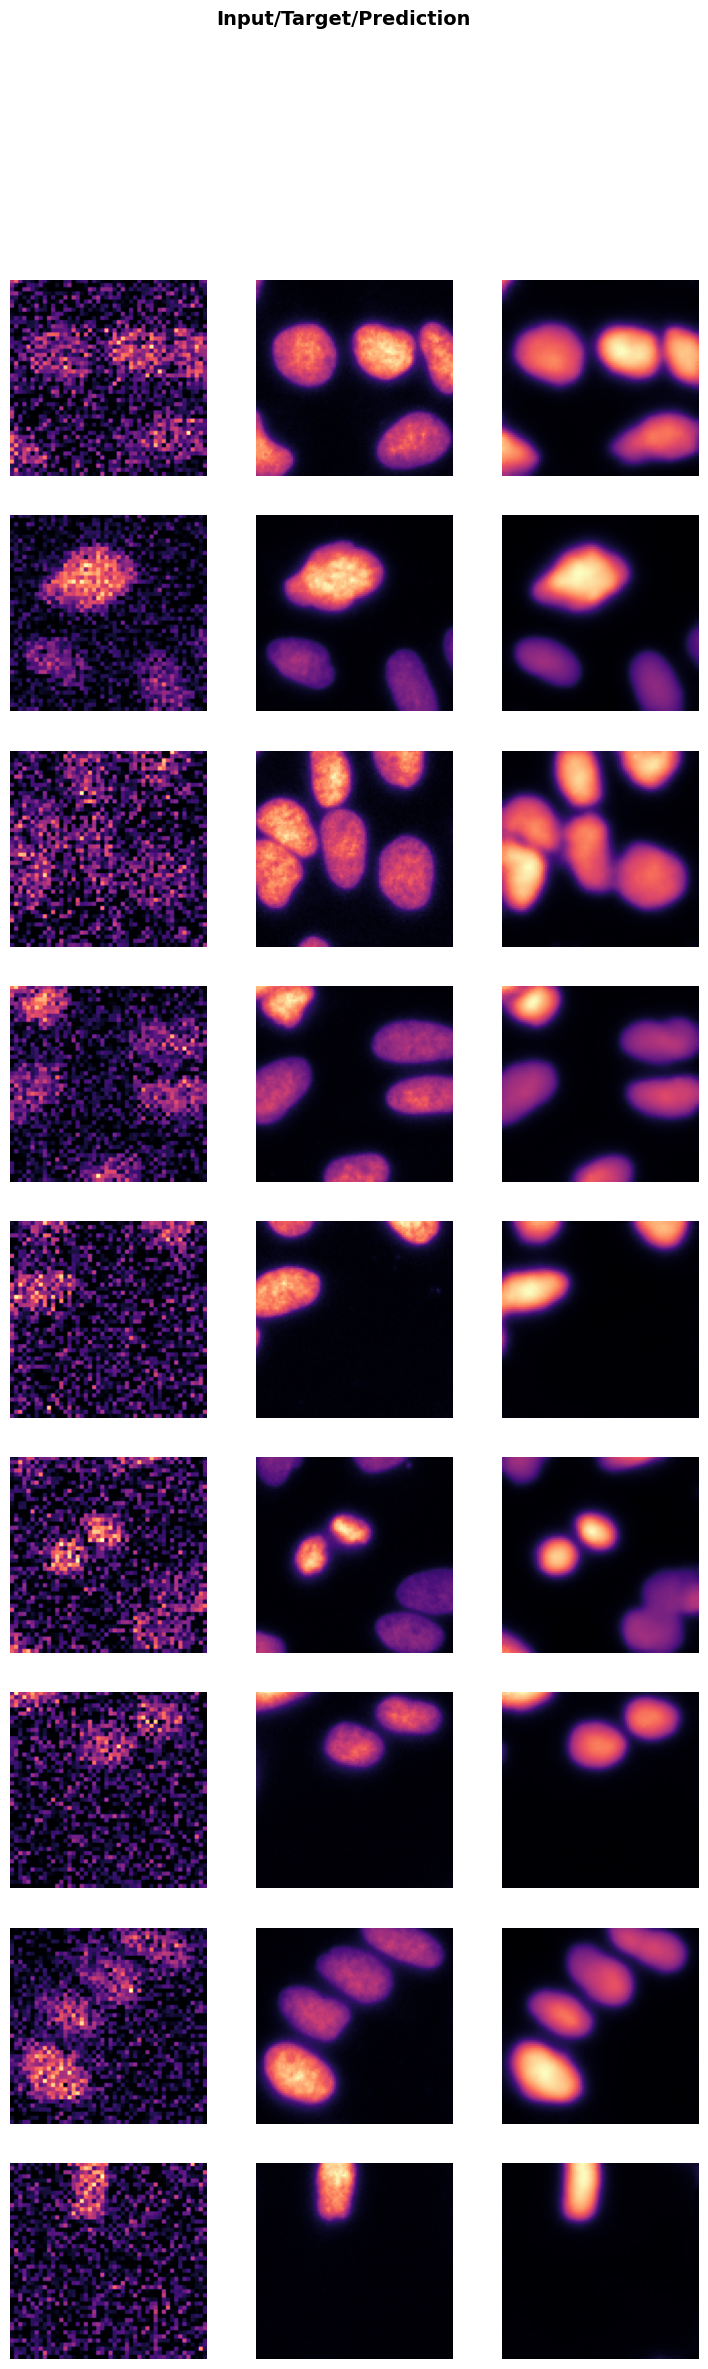

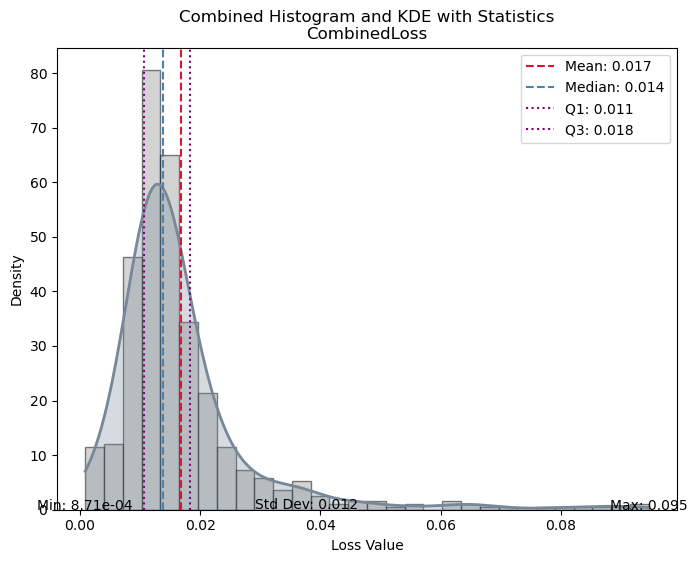

Value
CombinedLoss                
Mean                0.016833
Median              0.013806
Standard Deviation  0.012330
Min                 0.000871
Max                 0.094672
Q1                  0.010612
Q3                  0.018312

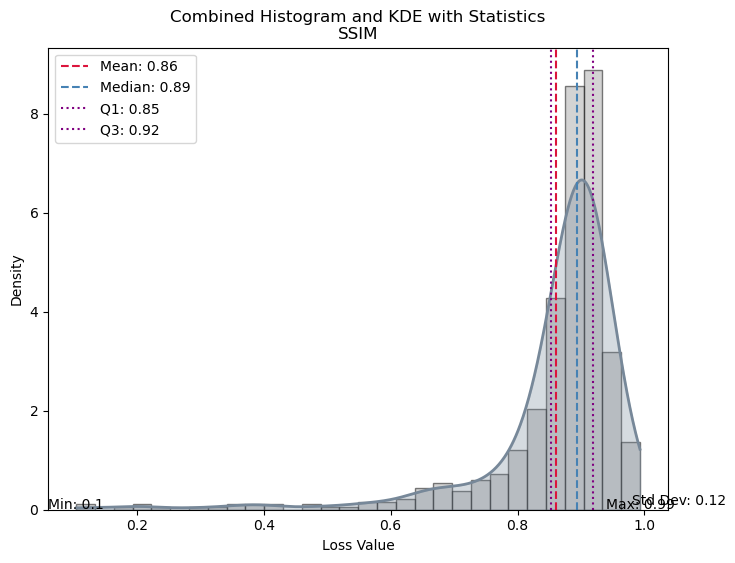

Value
SSIM                        
Mean                0.860965
Median              0.893404
Standard Deviation  0.118673
Min                 0.104494
Max                 0.992975
Q1                  0.852688
Q3                  0.918993

In [ ]:
test_X_path = '../_data/U2OS/128a57f165e1044e34d9a6ef46e66b3c-snr_7_binning_2.zip.unzip/test/low/'

test_data = data.test_dl(get_image_files(test_X_path), with_labels=True)

evaluate_model(trainer, test_data, metrics=SSIMMetric(2));